In [3]:
import numpy as np

In [5]:
import torch
from pathlib import Path
from omegaconf import OmegaConf
import hydra

#from plan import load_model  # uses the same loader as plan.py
from load_model_light import load_model
from utils import slice_trajdict_with_t

# --- configure paths ---
model_path = Path(
    "/home/hgf_hmgu/hgf_gib4562/dino_wm/outputs/2026-02-06/18-29-56")
ckpt_epoch = "latest"  # or "final"

# --- load model config ---
cfg = OmegaConf.load(model_path / "hydra.yaml")

# --- load dataset (valid split) ---
_, traj_dset = hydra.utils.call(
    cfg.env.dataset,
    num_hist=cfg.num_hist,
    num_pred=cfg.num_pred,
    frameskip=cfg.frameskip,
)
dset = traj_dset["valid"]

# --- load model checkpoint ---
ckpt_path = model_path / "checkpoints" / f"model_{ckpt_epoch}.pth"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = load_model(ckpt_path, cfg, cfg.num_action_repeat, device=device)
model.eval()

# --- sample a trajectory and build inputs ---
obs, act, state, _ = dset[0]  # full episode
obs_0 = {
    k: v[:cfg.num_hist].unsqueeze(0).to(device) for k, v in obs.items()
}  # (B, T, ...)
actions = act[:20].unsqueeze(0).to(device)  # rollout for 20 steps (adjust)

# --- encode initial window (latent representation) ---
with torch.no_grad():
    z_obs_init = model.encode_obs(
        obs_0)  # dict with 'visual' and 'proprio' latents

# --- rollout in latent space ---
with torch.no_grad():
    z_obses, z_all = model.rollout(obs_0, actions)
    z_last = slice_trajdict_with_t(z_obses, start_idx=-1, end_idx=None)

print("Initial latent visual shape:", z_obs_init["visual"].shape)
print("Rollout latent visual shape:", z_obses["visual"].shape)
print("Last-step latent shape:", z_last["visual"].shape)

[[0], [1]]
Resuming from epoch 1: /home/hgf_hmgu/hgf_gib4562/dino_wm/outputs/2026-02-06/18-29-56/checkpoints/model_latest.pth
num_action_repeat: 1
num_proprio_repeat: 1
proprio encoder: ProprioceptiveEmbedding(
  (patch_embed): Conv1d(4, 10, kernel_size=(1,), stride=(1,))
)
action encoder: ProprioceptiveEmbedding(
  (patch_embed): Conv1d(1, 10, kernel_size=(1,), stride=(1,))
)
proprio_dim: 10, after repeat: 10
action_dim: 10, after repeat: 10
emb_dim: 532
Model emb_dim:  532


/home/hgf_hmgu/hgf_gib4562/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hgf_hmgu/hgf_gib4562/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/hgf_hmgu/hgf_gib4562/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current def

Initial latent visual shape: torch.Size([1, 2, 1, 512])
Rollout latent visual shape: torch.Size([1, 21, 1, 512])
Last-step latent shape: torch.Size([1, 1, 1, 512])


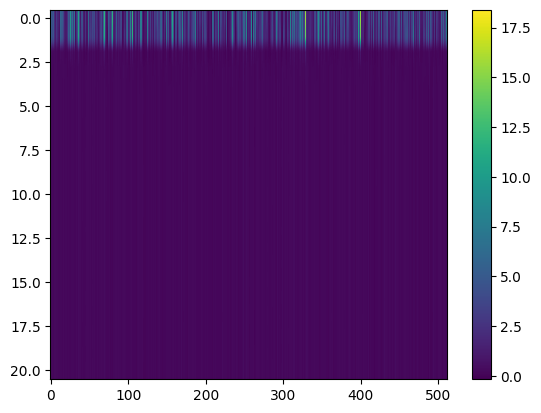

In [15]:
import matplotlib.pyplot as plt

plt.imshow(z_obses["visual"].squeeze().detach().cpu().numpy(), aspect='auto')
plt.colorbar()